In [557]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import subprocess
import pymongo
import motor.motor_asyncio
import bson
import bson.json_util
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument

import datetime
import time
import os

from scipy import interpolate

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

import multiprocessing as mp

import gc

from numpy.random import default_rng

tf.enable_v2_behavior()
#tf.config.experimental.enable_tensor_float_32_execution(False)
print("TensorFloat-32: " + str(tf.config.experimental.tensor_float_32_execution_enabled()))

TensorFloat-32: True


In [558]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [559]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [563]:
exchange = "coinbasepro"
#exchange = "bitmex"
#exchange = "gdax"
#exchange = "kraken"
orderbook_path = f"orderbook_scaled_{exchange}"

In [564]:
orderbook_table = pq.read_table(f'/data/{orderbook_path}.parquet')
orderbook_df = orderbook_table.to_pandas()

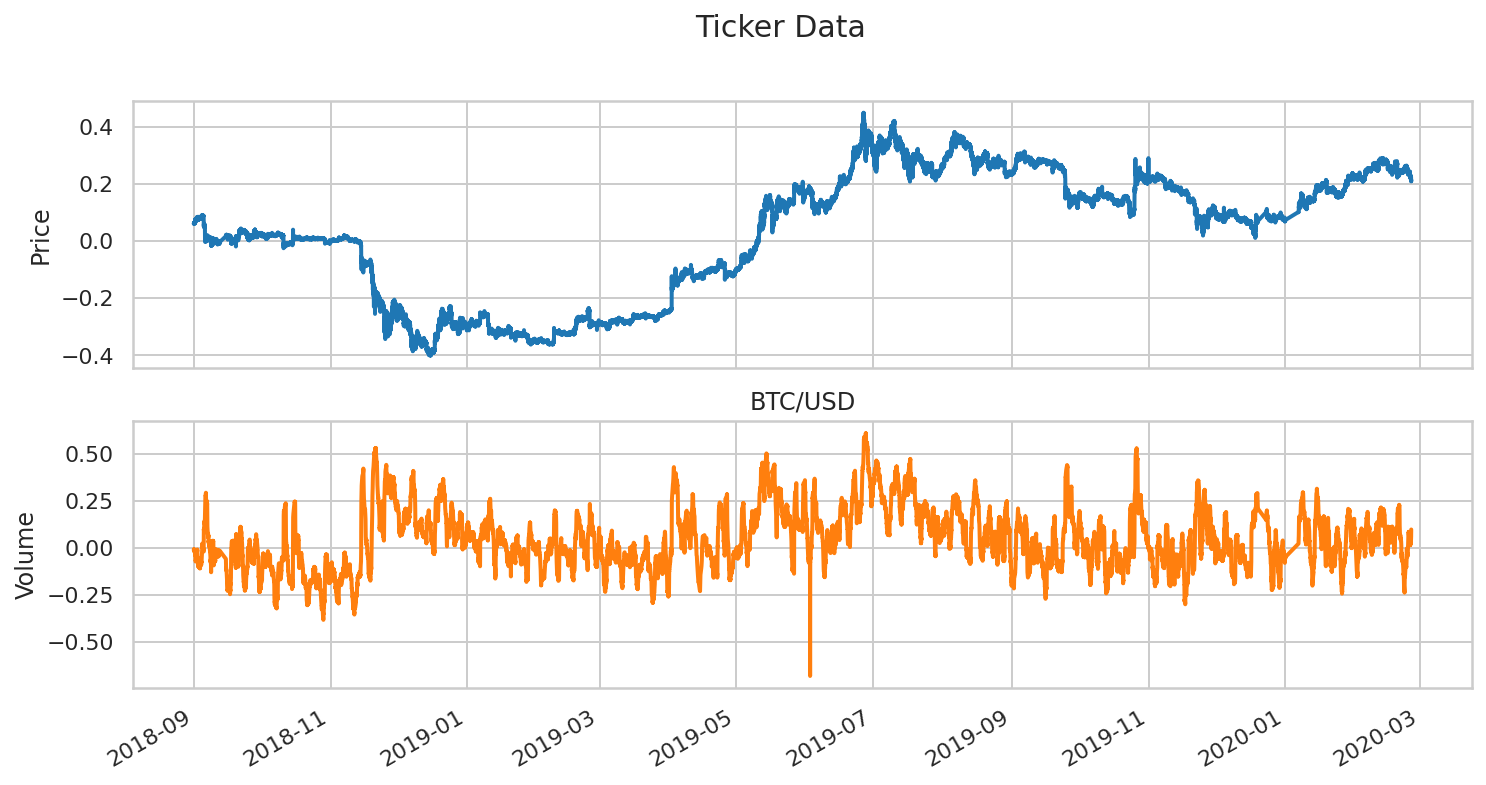

In [565]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(orderbook_df.index, orderbook_df.Price, lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(orderbook_df.index, orderbook_df.Volume, lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()

In [566]:
orderbook_df

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:05.311,0.060298,-0.008501,-1.0,-1.000000,0.366702,-0.243579,-0.378473,-0.368778,-0.359083,-0.349387,...,0.336916,0.389931,0.349751,0.318557,0.382015,0.357203,0.369771,0.450971,-1.0,-1.0
2018-09-01 00:00:35.284,0.060297,-0.008501,-1.0,-1.000000,0.393788,-0.190507,-0.225381,-0.215686,-0.205991,-0.196296,...,0.267534,0.408540,0.350390,0.319569,0.403683,0.358004,0.370131,0.365658,-1.0,-1.0
2018-09-01 00:01:04.970,0.060298,-0.008501,-1.0,-1.000000,0.460801,0.275965,0.285645,0.295340,0.305035,0.314730,...,-0.055038,0.112686,0.264262,0.359787,0.400802,0.369547,0.398341,0.444336,-1.0,-1.0
2018-09-01 00:01:40.193,0.061071,-0.008501,-1.0,-1.000000,0.463231,0.038117,0.046331,0.056026,0.065721,0.075416,...,0.137283,0.393280,0.269899,0.374977,0.383630,0.410064,0.399178,-1.000000,-1.0,-1.0
2018-09-01 00:02:15.602,0.061071,-0.008501,-1.0,-1.000000,0.428290,0.037451,0.046379,0.056074,0.065769,0.075464,...,0.366069,0.352843,0.346273,0.374950,0.387078,0.378196,-1.000000,-1.000000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 02:46:03.694,0.214348,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.435687,0.259608,0.456857,0.413994,0.407310,0.312603,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:46:33.837,0.214833,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.320040,0.384688,0.382834,0.447527,0.421526,0.443047,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:47:02.991,0.214824,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.288242,0.379237,0.345939,0.379853,0.404033,0.485482,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:47:33.275,0.215094,0.097036,-1.0,0.425374,-0.006984,0.002712,0.012407,0.022102,0.031797,0.041492,...,0.355501,0.390026,0.369412,0.481740,0.410387,0.409763,-1.000000,-1.000000,-1.0,-1.0


In [567]:
def create_model_generator(cell_sizes, input_seq_len, n_features, 
    latent_dim=10, activation='gelu', layer_type='LSTM', 
    repeat_noise=True):
    
    layer_constructor = getattr(layers, layer_type)
    n_layers = len(cell_sizes)

    if repeat_noise:
        input = keras.Input(name="noise_input", 
            shape=(latent_dim))

        repeat_layer = layers.RepeatVector(input_seq_len, 
            name="repeat_noise")
        input_layer = repeat_layer(input)
    else:
        input = keras.Input(name="noise_input", 
            shape=(input_seq_len, latent_dim))
        input_layer = input

    rnn_layers = [
        layer_constructor(cell_size, 
            name=f"{layer_type}_{i}", return_sequences=True, 
            return_state=(i!=(n_layers-1))
        ) for i, cell_size in enumerate(cell_sizes)]

    rnn_output = rnn_layers[0](input_layer)

    for i, cell_size in enumerate(cell_sizes[1:]):
        
        rnn_output = rnn_layers[i+1](rnn_output)
        

    out_layer = layers.Dense(n_in_features, 
        name="out_layer", activation=activation)

    output = out_layer(rnn_output)

    model = models.Model(input, output)
    return model

In [568]:
inputs = orderbook_df.columns
input_seq_len = 100
n_in_features = len(inputs)
batch_size = 128
latent_dim = 10
cellsize = 128
#layer_type='GRU'
layer_type='LSTM'

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
repeate_noise (RepeatVector) (None, 100, 10)           0         
_________________________________________________________________
LSTM_0 (LSTM)                (None, 100, 128)          71168     
_________________________________________________________________
out_layer (Dense)            (None, 100, 104)          13416     
Total params: 84,584
Trainable params: 84,584
Non-trainable params: 0
_________________________________________________________________


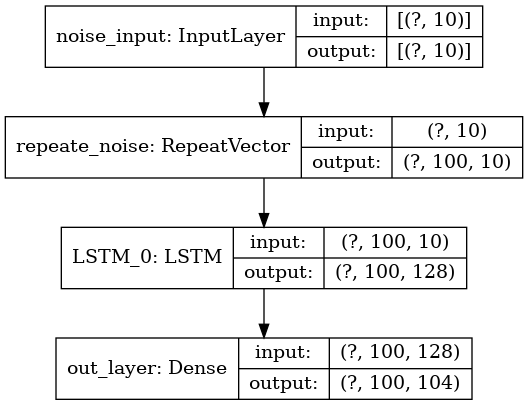

In [569]:
model_1 = create_model_generator(cell_sizes=[cellsize], input_seq_len=input_seq_len, n_features=n_in_features, latent_dim=latent_dim, layer_type=layer_type)
model_1.summary()
keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

Model: "functional_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
repeate_noise (RepeatVector)    (None, 100, 10)      0           noise_input[0][0]                
__________________________________________________________________________________________________
LSTM_0 (LSTM)                   [(None, 100, 128), ( 71168       repeate_noise[0][0]              
__________________________________________________________________________________________________
LSTM_1 (LSTM)                   (None, 100, 128)     131584      LSTM_0[0][0]                     
                                                                 LSTM_0[0][1]         

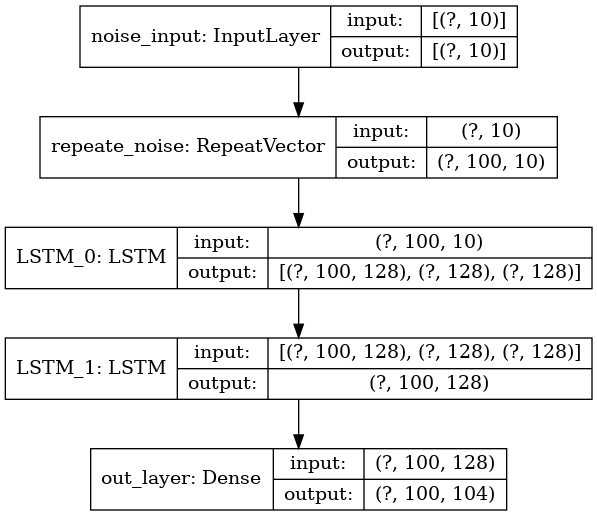

In [570]:
model_2 = create_model_generator(cell_sizes=[cellsize,cellsize], input_seq_len=input_seq_len, n_features=n_in_features, latent_dim=latent_dim,  layer_type=layer_type)
model_2.summary()
keras.utils.plot_model(model_2, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

In [571]:
def create_model_discriminator(cell_sizes, input_seq_len, 
    n_features, _could_use_gpu_kernel=False, 
    layer_type='LSTM'):

    layer_constructor = getattr(layers, layer_type)
    n_layers = len(cell_sizes)

    input = keras.Input(name="lob_input", 
        shape=(input_seq_len, n_features))
    input_layer = input

    rnn_layers  = [
        layer_constructor(cell_size, 
            name=f"{layer_type}_{i}", return_sequences=True, 
            return_state=(i!=(n_layers-1))
        ) for i, cell_size in enumerate(cell_sizes)
    ]
    for layer in rnn_layers:
        # required for second order derivatives
        layer._could_use_gpu_kernel = _could_use_gpu_kernel

    rnn_output = rnn_layers[0](input_layer)

    for i, cell_size in enumerate(cell_sizes[1:]):
        
        rnn_output = rnn_layers[i+1](rnn_output)

    reshape = layers.Reshape((input_seq_len*cell_sizes[-1],), 
        name="reshape_rnn_out")

    rnn_output_reshaped = reshape(rnn_output)

    out_layer = layers.Dense(1, name="out_layer", activation=None)

    output = out_layer(rnn_output_reshaped)

    model = models.Model(input, output)
    return model

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lob_input (InputLayer)       [(None, 100, 104)]        0         
_________________________________________________________________
LSTM_0 (LSTM)                (None, 100, 128)          119296    
_________________________________________________________________
reshape_rnn_out (Reshape)    (None, 12800)             0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 12801     
Total params: 132,097
Trainable params: 132,097
Non-trainable params: 0
_________________________________________________________________


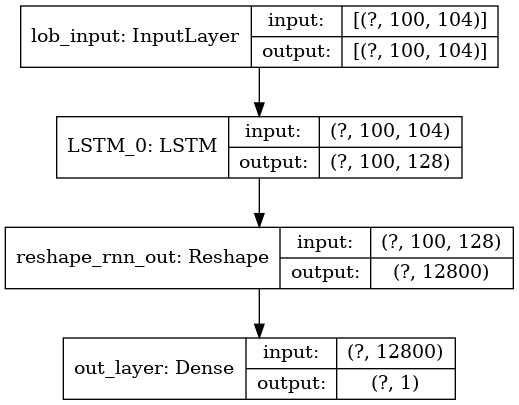

In [572]:
model_1_d = create_model_discriminator(cell_sizes=[cellsize], input_seq_len=input_seq_len, n_features=n_in_features,  layer_type=layer_type)
model_1_d.summary()
keras.utils.plot_model(model_1_d, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lob_input (InputLayer)          [(None, 100, 104)]   0                                            
__________________________________________________________________________________________________
LSTM_0 (LSTM)                   [(None, 100, 128), ( 119296      lob_input[0][0]                  
__________________________________________________________________________________________________
LSTM_1 (LSTM)                   (None, 100, 128)     131584      LSTM_0[0][0]                     
                                                                 LSTM_0[0][1]                     
                                                                 LSTM_0[0][2]                     
______________________________________________________________________________________

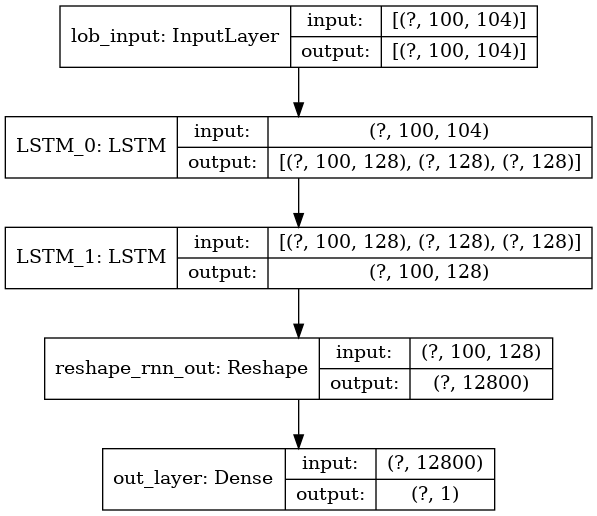

In [573]:
model_2_d = create_model_discriminator(cell_sizes=[cellsize,cellsize], input_seq_len=input_seq_len, n_features=n_in_features, layer_type=layer_type)
model_2_d.summary()
keras.utils.plot_model(model_2_d, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

In [574]:
size_factor = 1
range_factor = 0.9
start_factor = 0.0
start_start_points = int(len(orderbook_df)*start_factor)    
end_start_points = int(len(orderbook_df)*range_factor)    
total_start_points = int((end_start_points-start_start_points-input_seq_len)*size_factor)
orderbook_df.iloc[[start_start_points, end_start_points-1, len(orderbook_df) - 1]]

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:05.311,0.060298,-0.008501,-1.0,-1.000000,0.366702,-0.243579,-0.378473,-0.368778,-0.359083,-0.349387,...,0.336916,0.389931,0.349751,0.318557,0.382015,0.357203,0.369771,0.450971,-1.0,-1.0
2019-12-30 07:32:18.052,0.089168,-0.016672,-1.0,-1.000000,0.472740,0.103695,0.113390,0.123085,0.132780,0.142475,...,0.284609,0.463293,0.393521,0.416579,0.476208,0.486571,0.491298,-0.630382,-1.0,-1.0
2020-02-26 02:48:03.293,0.215593,0.097036,-1.0,0.286805,-0.154753,-0.145058,-0.135363,-0.125668,-0.115973,-0.106278,...,0.367942,0.071101,0.413381,0.462598,0.415828,0.228115,-1.000000,-1.000000,-1.0,-1.0


In [575]:
rng = default_rng(0)

In [576]:
start_orderbook_ilocs = rng.choice(range(start_start_points, end_start_points-input_seq_len), total_start_points, replace = False)
len(orderbook_df), len(start_orderbook_ilocs)

(1441026, 1296823)

In [577]:
def clean_start_ilocs(orderbook_df, start_orderbook_ilocs, input_seq_len, timestep = 30, tolerance = 1.1):
    orderbook_df_index = orderbook_df.index
    start_orderbook_ts = orderbook_df.index[start_orderbook_ilocs]
    end_orderbook_ts = orderbook_df.index[start_orderbook_ilocs+input_seq_len-1]
    start_orderbook_ilocs_clean = start_orderbook_ilocs[
        np.where((end_orderbook_ts - start_orderbook_ts).seconds < (input_seq_len)*timestep*tolerance)
    ]
    return start_orderbook_ilocs_clean

start_orderbook_ilocs_clean = clean_start_ilocs(orderbook_df, start_orderbook_ilocs, input_seq_len)
len(start_orderbook_ilocs_clean)

1170398

In [578]:
def get_training_slice(orderbook_df, loc, input_seq_len, scale_min_to_zero=True, as_type='float'):
    data_slice = orderbook_df.iloc[np.r_[loc:loc+input_seq_len]]
    if scale_min_to_zero:
        return (data_slice.index,
                (data_slice.astype(as_type).to_numpy()+1)/2)
    else:
        return (data_slice.index,
                data_slice.astype(as_type).to_numpy())


get_training_slice(orderbook_df, start_orderbook_ilocs_clean[0], input_seq_len, as_type='float32')

(DatetimeIndex(['2019-07-02 16:05:19.446000', '2019-07-02 16:05:50.277000',
                '2019-07-02 16:06:20.490000', '2019-07-02 16:06:49.424000',
                '2019-07-02 16:07:20.218000', '2019-07-02 16:07:48.954000',
                '2019-07-02 16:08:19.956000', '2019-07-02 16:08:49.186000',
                '2019-07-02 16:09:19.654000', '2019-07-02 16:09:50.876000',
                '2019-07-02 16:10:19.951000', '2019-07-02 16:10:51.825000',
                '2019-07-02 16:11:23.479000', '2019-07-02 16:11:53.119000',
                '2019-07-02 16:12:25.448000', '2019-07-02 16:12:53.409000',
                '2019-07-02 16:13:23.510000', '2019-07-02 16:13:54.274000',
                '2019-07-02 16:14:24.833000', '2019-07-02 16:14:54.795000',
                '2019-07-02 16:15:24.695000', '2019-07-02 16:15:55.260000',
                '2019-07-02 16:16:25.323000', '2019-07-02 16:16:57.455000',
                '2019-07-02 16:17:27.968000', '2019-07-02 16:17:58.807000',
            

In [579]:
def get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        as_type='float',
        rng = None):
    if not rng:
        rng = default_rng(0)
    
    start_start_points = int(len(orderbook_df)*start_factor)    
    end_start_points = int(len(orderbook_df)*range_factor)    
    total_start_points = int((end_start_points-start_start_points-input_seq_len)*size_factor)
    

    while True:
        start_orderbook_ilocs = rng.choice(range(start_start_points, end_start_points), total_start_points, replace = False)
        start_orderbook_ilocs_clean = clean_start_ilocs(orderbook_df, start_orderbook_ilocs, input_seq_len)
        def training_sequence():
            for loc in start_orderbook_ilocs_clean:
                yield get_training_slice(orderbook_df, loc, input_seq_len, as_type=as_type)
        yield (len(start_orderbook_ilocs_clean),training_sequence)


sample_sequences = get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        as_type='float32',   
        size_factor=10/len(orderbook_df))
for i, s in enumerate(sample_sequences):
    if i >= 2:
        break
    print(f'Sequence {i}: Size {s[0]}')
    for j, d in enumerate(s[1]()):
        print(f'Set {i}.{j}: Start {d[0][0]}, Type {d[1].dtype} Shapes {d[1].shape}')

Sequence 0: Size 6
Set 0.0: Start 2019-10-18 10:41:35.306000, Type float32 Shapes (100, 104)
Set 0.1: Start 2019-05-14 07:35:50.147000, Type float32 Shapes (100, 104)
Set 0.2: Start 2019-01-25 22:47:37.186000, Type float32 Shapes (100, 104)
Set 0.3: Start 2019-01-08 10:05:11.990000, Type float32 Shapes (100, 104)
Set 0.4: Start 2018-09-22 01:11:24.979000, Type float32 Shapes (100, 104)
Set 0.5: Start 2019-07-11 16:31:50.725000, Type float32 Shapes (100, 104)
Sequence 1: Size 8
Set 1.0: Start 2019-06-05 20:22:18.899000, Type float32 Shapes (100, 104)
Set 1.1: Start 2019-07-09 12:14:21.960000, Type float32 Shapes (100, 104)
Set 1.2: Start 2019-11-26 15:28:34.335000, Type float32 Shapes (100, 104)
Set 1.3: Start 2019-07-26 19:16:52.424000, Type float32 Shapes (100, 104)
Set 1.4: Start 2019-10-02 04:57:56.906000, Type float32 Shapes (100, 104)
Set 1.5: Start 2019-01-11 22:07:02.172000, Type float32 Shapes (100, 104)
Set 1.6: Start 2019-05-29 08:05:29.887000, Type float32 Shapes (100, 104)


In [580]:
def get_training_sequence(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        as_type='float',
        rng = None):
    sequence_generator = get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        size_factor,
        range_factor, 
        start_factor,
        as_type,
        rng)
    for i, s in enumerate(sequence_generator):
        print(f'Input_sequence {i}: Size {s[0]}')            
        for j, d in enumerate(s[1]()):
            yield d[1]

sample_sequence = get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        size_factor=10/len(orderbook_df))
for i, s in enumerate(sample_sequence):
    if i >= 20:
        break


sample_sequence = get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        )
for i, s in enumerate(sample_sequence):
    if i >= 1:
        break
    print(s)


Input_sequence 0: Size 6
Input_sequence 1: Size 8
Input_sequence 2: Size 5
Input_sequence 3: Size 8
Input_sequence 0: Size 1170406
[[0.53302666 0.44274471 0.         ... 0.         0.         0.        ]
 [0.53303815 0.44277419 0.         ... 0.         0.         0.        ]
 [0.53305831 0.44279707 0.         ... 0.         0.         0.        ]
 ...
 [0.53364388 0.4448369  0.         ... 0.         0.         0.        ]
 [0.53349896 0.44487158 0.         ... 0.         0.         0.        ]
 [0.53353882 0.44490262 0.         ... 0.         0.         0.        ]]


In [581]:
def get_training_dataset(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        as_type='float32',
        rng = None):
    def generator():
        return  get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        size_factor,
        range_factor, 
        start_factor,
        as_type,
        rng)
    return tf.data.Dataset.from_generator(
        generator, 
        args=[], 
        output_types = tf.float32,
        output_shapes = tf.TensorShape([input_seq_len, n_in_features])
    )

list(get_training_dataset(orderbook_df, 
        input_seq_len).batch(2).take(2).as_numpy_iterator())

Input_sequence 0: Size 1170406


[array([[[0.53302664, 0.4427447 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.53303814, 0.44277418, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.5330583 , 0.44279706, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.5336439 , 0.4448369 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.53349894, 0.44487157, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.5335388 , 0.44490263, 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.33497393, 0.49741802, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.3350368 , 0.4970142 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.33500376, 0.49676478, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.33433998, 0.4920476 , 0.        , ..., 0.67253643,
          0.        , 0.

In [582]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        input_seq_len,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.input_seq_len = input_seq_len
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def get_config(self):
        return {
            "discriminator": self.discriminator,
            "generator":self.generator,
            "latent_dim":self.latent_dim,
            "input_seq_len":self.input_seq_len,
            "d_steps":self.d_steps,
            "gp_weight":self.gp_weight
        }

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_data, fake_data):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated data
        and added to the discriminator loss.
        """
        # Get the interpolated data
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_data - real_data
        interpolated = real_data + alpha * diff 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated data.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated data.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Get the batch size
        batch_size = tf.shape(real_data)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            if self.input_seq_len:
                random_latent_vectors = tf.random.normal(
                    shape=(batch_size, self.input_seq_len, self.latent_dim)
                )
            else:
                random_latent_vectors = tf.random.normal(
                    shape=(batch_size, self.latent_dim)
                )
            with tf.GradientTape() as tape:
                # Generate fake data from the latent vector
                fake_data = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake data
                fake_logits = self.discriminator(fake_data, training=True)
                # Get the logits for the real data
                real_logits = self.discriminator(real_data, training=True)

                # Calculate the discriminator loss using the fake and real data logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_data, fake_data)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        if self.input_seq_len:
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.input_seq_len, self.latent_dim)
            )
        else:
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            generated_data = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake data
            gen_img_logits = self.discriminator(generated_data, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


In [583]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=1, input_seq_len=100, checkpoint_filepath=None):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.input_seq_len = input_seq_len
        self.checkpoint_filepath = checkpoint_filepath

    def on_epoch_end(self, epoch, logs=None):
        if checkpoint_filepath:
            g_path = checkpoint_filepath.replace("{loss","{g_loss").format(**{**{'epoch':epoch, 'type':'gen'},**logs})
            self.model.generator.save(g_path)
            d_path = checkpoint_filepath.replace("{loss","{d_loss").format(**{**{'epoch':epoch, 'type':'disc'},**logs})
            self.model.discriminator.save(d_path)

In [584]:
g_model= model_2
d_model= model_2_d

In [589]:
learning_rate=0.0002

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 5000

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    input_seq_len=None,
    discriminator_extra_steps=5,
    gp_weight=10,
)

# Instantiate the customer `GANMonitor` Keras callback.
checkpoint_filepath = f'/data/checkpoint/gan_{layer_type}_{cellsize}_{latent_dim}_{input_seq_len}.{wgan.d_steps}_{wgan.gp_weight}_{learning_rate}.{{epoch:04d}}-{{loss:.6f}}-{{type}}.hdf5'
cbk = GANMonitor(num_img=3, input_seq_len=input_seq_len, latent_dim=latent_dim, checkpoint_filepath=checkpoint_filepath)


# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

checkpoint_filepath

'/data/checkpoint/gan_LSTM_128_10_100.3_10_0.0002.{epoch:04d}-{loss:.6f}-{type}.hdf5'

In [590]:
def train_model(model, training_dataset, epochs, steps_per_epoch,
    callbacks=[cbk],
    batch_size=batch_size,
    initial_epoch=0):
    history = model.fit(training_dataset.batch(batch_size),
                            #batch_size=batch_size,
                            epochs=epochs,
                            initial_epoch=initial_epoch,
                            steps_per_epoch=steps_per_epoch,
                            callbacks=callbacks)
                            
    return history

In [591]:
training_dataset = get_training_dataset(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9
        )
it=training_dataset.batch(batch_size).as_numpy_iterator()
%timeit -r 1 wgan.train_step(next(it))

Input_sequence 0: Size 1170406
7.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [592]:
model = wgan

training_dataset = get_training_dataset(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9
        )
        
start_time = time.time()
train_model(model, training_dataset, epochs=epochs, steps_per_epoch=100, batch_size=batch_size, initial_epoch=0)
end_time = time.time()
run_time = (end_time - start_time)/60
run_time

Epoch 1/5000
Input_sequence 0: Size 1170406
100/100 [==============================] - 478s 5s/step - d_loss: 39157.2691 - g_loss: 43.3041
Epoch 2/5000
100/100 [==============================] - 481s 5s/step - d_loss: 58820.9762 - g_loss: 44.7018
Epoch 3/5000
100/100 [==============================] - 469s 5s/step - d_loss: 161171.9889 - g_loss: 8.9524
Epoch 4/5000
100/100 [==============================] - 480s 5s/step - d_loss: 9140.8474 - g_loss: 11.2110
Epoch 5/5000
100/100 [==============================] - 476s 5s/step - d_loss: 2652.9527 - g_loss: 12.2948
Epoch 6/5000
100/100 [==============================] - 478s 5s/step - d_loss: 3790.7486 - g_loss: 5.1109
Epoch 7/5000
100/100 [==============================] - 478s 5s/step - d_loss: 42370.6100 - g_loss: 6.9801
Epoch 8/5000
100/100 [==============================] - 480s 5s/step - d_loss: 20970.4499 - g_loss: 4.4166
Epoch 9/5000
100/100 [==============================] - 468s 5s/step - d_loss: 1756.5236 - g_loss: 4.4201
Epoch

KeyboardInterrupt: 

In [ ]:
[
    np.max(np.abs((
        [np.max(l) for l in model.discriminator.get_weights()],
        [np.min(l) for l in model.discriminator.get_weights()]
        ))),
    np.max(np.abs((
        [np.max(l) for l in model.generator.get_weights()],
        [np.min(l) for l in model.generator.get_weights()]
        )))
]

In [ ]:
random_latent_vectors = tf.random.normal(shape=(2, input_seq_len, latent_dim))
generated_data = model.generator(random_latent_vectors)
generated_data.numpy()[0].T

In [114]:
model.discriminator(generated_data)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-1.3078387 ],
       [ 0.30908978]], dtype=float32)>

In [171]:
test_dataset = get_training_dataset(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        range_factor = 0.9,
        rng=default_rng()
        )
next(test_dataset.as_numpy_iterator()).T

Input_sequence 0: Size 1170410


array([[0.35006303, 0.3501487 , 0.3498659 , ..., 0.34958977, 0.34958977,
        0.34958977],
       [0.6438329 , 0.64377904, 0.6437143 , ..., 0.6362932 , 0.6361783 ,
        0.63604224],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.6796352 , ..., 0.7240886 , 0.7269629 ,
        0.72398967],
       [0.        , 0.        , 0.        , ..., 0.13678512, 0.13678527,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
model_pathes=(
    sorted(glob.glob('/data/checkpoint/gan_LSTM_128_10_100.5_10_0.0002*gen.hdf5'), key=os.path.getmtime)[-1],
    sorted(glob.glob('/data/checkpoint/gan_LSTM_128_10_100.5_10_0.0002*disc.hdf5'), key=os.path.getmtime)[-1]
)
print(model_pathes)
g_model = models.load_model(model_pathes[0])
d_model = models.load_model(model_pathes[1])
g_model.summary()
d_model.summary()

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    input_seq_len=input_seq_len,
    discriminator_extra_steps=3,
    gp_weight=1,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)
model = wgan

In [ ]:
[
    np.max(np.abs((
        [np.max(l) for l in model.discriminator.get_weights()],
        [np.min(l) for l in model.discriminator.get_weights()]
        ))),
    np.max(np.abs((
        [np.max(l) for l in model.generator.get_weights()],
        [np.min(l) for l in model.generator.get_weights()]
        )))
]

In [ ]:
random_latent_vectors = tf.random.normal(shape=((128,) + model.generator.layers[0].input_shape[0][1:]))
generated_data = model.generator(random_latent_vectors)
scores = model.discriminator(generated_data)
best_data=np.argmax(scores)
print((best_data, scores[best_data].numpy()[0]))
print(generated_data.numpy()[best_data].T)
print((0, scores[0].numpy()[0]))
print(generated_data.numpy()[0].T)
print(scores.numpy().T)

In [ ]:
test_dataset = get_training_dataset(orderbook_df, 
        input_seq_len, 
        size_factor = 1,
        start_factor=0.9,
        range_factor = 0.99,
        rng=default_rng()
        )
print(next(test_dataset.as_numpy_iterator()).T)
model.discriminator(next(iter(test_dataset.batch(128)))).numpy().reshape(-1)